In [8]:
import os
import numpy as np  
import csv # to read string (color_*.jpg)
from IPython.display import clear_output

import shutil 
from scipy.signal import butter, lfilter, filtfilt       # for LPF, HPF
import matplotlib.pyplot as plt

np.random.seed(7)
np.set_printoptions(precision=4)

rootDir = "D:/바탕화면/Dataset/TUG/actLabel"
expertFolder = "/" + "2021_01_27_saveResults_김윤환"  # --- 변경 할 부분
viewFolder = "/" + "0_sideView"

print(" [Home Dir.] Current path", os.getcwd())  

# --- 변경 할 부분
# DateFolder = "/" + "2020_11_03"  
# DateFolder = "/" + "2020_11_20_v1"
# DateFolder = "/" + "2020_11_20_v2"  
# DateFolder = "/" + "2020_11_23"
# DateFolder = "/" + "2020_12_09"   # JDW 환자 
# DateFolder = "/" + "2020_12_30" # 연대+나+유성 뇌졸중 보행 패턴 모방 .. 몸을 내던지듯 앉음.. 
DateFolder = "/" + "2021_01_20"
# DateFolder = "/" + "dd"  
# DateFolder = "/" + "dd"


datasetDir = rootDir + expertFolder + viewFolder + DateFolder
os.chdir(datasetDir) ; print(" [Walking Dir.] Current path  ", os.getcwd())  # -- Dataset 있는 곳으로 경로alse)


 [Home Dir.] Current path D:\바탕화면\Dataset\TUG\actLabel\2021_01_27_saveResults_김미경\0_sideView\2021_01_20
 [Walking Dir.] Current path   D:\바탕화면\Dataset\TUG\actLabel\2021_01_27_saveResults_김윤환\0_sideView\2021_01_20


### Functions to get row/lpf skeleton data and actionLabel

In [1]:
def get_actFrameNumber(filedir, filename, saveDir): 
    actFrame = []
    with open(filedir +"/" + filename, 'r', encoding='utf-8') as readCSV:
        data = readCSV.read()
        lines = data.split("\n") # lines[0] = header, [1] = act label data
        tmpLabel = lines[1].split(",")
       
        for i in range(len(tmpLabel)):           
            actFrame.append( int(tmpLabel[i].split("_")[1].split(".")[0]) ) 
            shutil.copyfile(filedir +"/" + tmpLabel[i], saveDir +"/" +  tmpLabel[i] )
        return actFrame
      
        
        
        
safeTimeforBody = 66     
def get_pelvisData(filedir, file):
    csv_data_ = np.loadtxt(filedir+"/"+file, delimiter=',', dtype=str, skiprows=2, usecols=(1))
    line_num=csv_data_.shape[0]
    for i, v in enumerate(csv_data_):
        if v == " ":
            line_num = i
            break
    rawData = np.loadtxt(filedir+"/"+file, delimiter=',', skiprows=2, max_rows=line_num,  usecols=[0, 1, 2, 3, 97, 98, 99, 100])
    frameNum = rawData[:, 0]
    eachrawPelvis_x = rawData[:, 1]
    eachrawPelvis_y = rawData[:, 2]  # vertical axis = y
    eachrawPelvis_z = rawData[:, 3]
    
    timestamp_diff_msec = np.array([eachrawPelvis_x])
    for i in range(len(frameNum)):
        before_time_msec = rawData[i-1, 4] * 60 * 60 * 1000 + rawData[i-1, 5] * 60 * 1000 +  rawData[i-1, 6] * 1000 + rawData[i-1, 7] 
        current_time_msec = rawData[i, 4] * 60 * 60 * 1000 + rawData[i, 5] * 60 * 1000 + rawData[i, 6] * 1000 + rawData[i, 7]
        if i is 0:
            timestamp_diff_msec[0, i] = 0
        else:
            timestamp_diff_msec[0, i] = int(current_time_msec - before_time_msec)

            # check body -- Error check
            if timestamp_diff_msec[0, i] > safeTimeforBody:
                AssertionError("[Lose Body,No data] Can not export Data ")
                            
        time_sum_msec = 0
        eachTimestamp_sec = np.array(frameNum, dtype=float) # sec (?,1)
        for timeIdx in range(timestamp_diff_msec.shape[1]):
            time_sum_msec = int(time_sum_msec + timestamp_diff_msec[0, timeIdx])
            eachTimestamp_sec[timeIdx] = time_sum_msec / 1000  
           
    return frameNum, eachTimestamp_sec, eachrawPelvis_x, eachrawPelvis_y, eachrawPelvis_z
     
    
def get_LPFData(pelvis_x, pelvis_y, pelvis_z, cutoff_freq = 0.5, order=1):
    sampling_freq = 30
    number_of_samples = len(pelvis_y)
    normalized_cutoff_freq = 2 * cutoff_freq / sampling_freq
    numerator_coeffs, denominator_coeffs = butter(order, normalized_cutoff_freq)
    Filtered_x = filtfilt(numerator_coeffs, denominator_coeffs, pelvis_x)  # Phase shift 없음
    Filtered_y = filtfilt(numerator_coeffs, denominator_coeffs, pelvis_y)
    Filtered_z = filtfilt(numerator_coeffs, denominator_coeffs, pelvis_z)
    return Filtered_x, Filtered_y, Filtered_z
    
def get_normData(pelvis_x, pelvis_y, pelvis_z, normMethod = 'min_max'):    
    if normMethod == "min_max":
        normPelvis_x = (pelvis_x -np.min(pelvis_x)) / ( np.max(pelvis_x) - np.min(pelvis_x))
        normPelvis_y = (pelvis_y -np.min(pelvis_y)) / ( np.max(pelvis_y) - np.min(pelvis_y))
        normPelvis_z = (pelvis_z -np.min(pelvis_z)) / ( np.max(pelvis_z) - np.min(pelvis_z))
        
    elif normMethod == "z_score":
        normPelvis_x = (pelvis_x -np.mean(pelvis_x)) / np.std(pelvis_x)
        normPelvis_y = (pelvis_y -np.mean(pelvis_y)) / np.std(pelvis_y)
        normPelvis_z = (pelvis_z -np.mean(pelvis_z)) / np.std(pelvis_z)
        
    return normPelvis_x, normPelvis_y, normPelvis_z

    
def convert_act2oneHot(actFrame, frameNum):
    actionList = []
    for timeIdx in range(len(frameNum)):
        if (timeIdx < actFrame[0]):  # frame Num < move start fram (sit)
            actionList.append([1, 0, 0, 0, 0])
                    # moveStartIdx ~ startWalk 까지 (sit-stand)
        elif (timeIdx >= actFrame[0]) and (timeIdx < actFrame[1]):
            actionList.append([0, 1, 0, 0, 0])
                    # startWalk ~ turnStartIdx 까지 (walking)
        elif (timeIdx >= actFrame[1]) and (timeIdx < actFrame[2]):
            actionList.append([0, 0, 1, 0, 0])
                    # turnStartIdx ~ turnEndIdx 까지 (turning)
        elif (timeIdx >= actFrame[2]) and (timeIdx < actFrame[3]):
            actionList.append([0, 0, 0, 1, 0])
                    # turnEndIdx ~ startSitIdx 까지 (walking)
        elif (timeIdx >= actFrame[3]) and (timeIdx < actFrame[4]):
            actionList.append([0, 0, 1, 0, 0])
                    # startSitIdx ~ moveEndIdx 까지 (stand-sit)
        elif (timeIdx >= actFrame[4]) and (timeIdx < actFrame[5]):
            actionList.append([0, 0, 0, 0, 1])
                    # startSitIdx ~ moveEndIdx 까지 (sitting)
        elif (timeIdx >= actFrame[5]):
            actionList.append([1, 0, 0, 0, 0])
        else:
            AssertionError("Check getLabel_forEveryTrial func. in utils_labeling_all")
        oneTrial_actionList = np.array(actionList)
    return np.array(oneTrial_actionList)
    
def create_saveFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("Error: creating directory" + directory)


    
# def pltSkeleton(timeSec, pelvis_x, pelvis_y, pelvis_z, saveDir,saveFile, actLabel, addFolder="raw", actSplit="True", save=True):
#     fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))
#     title = addFolder + ": " + saveFile
    
#     ax[0].set_title(title)
#     ax[0].set_ylabel('Side axis(X) of Pelvis [mm]')
#     ax[1].set_ylabel('Vertical axis(Y) of Pelvis [mm]')
#     ax[2].set_ylabel('Depth Axis of Pelvis [mm]')
#     ax[2].set_xlabel('Time [Sec]')
    
#     ax[0].plot(timeSec, pelvis_x, "r--", lw=1, label="pelvis_x")
#     ax[1].plot(timeSec, pelvis_y, "g--", lw=1, label="pelvis_y")
#     ax[2].plot(timeSec, pelvis_z, "b--", lw=1, label="pelvis_z")
    
#     fig.legend()
#     plt.show()
#     #plt.pause(0.3)    
#     #plt.pause(0.03) 
    
#     if save:
#         saveDir = os.path.join(saveDir,addFolder)
#         create_saveFolder(saveDir)
#         fig.savefig(saveDir+"/"+saveFile)
#     plt.close()
    
def pltSkeleton(timeSec, pelvis_x, pelvis_y, pelvis_z, saveDir, saveFile,  actLabel,addFolder="raw", actSplit=True, save=True):
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))
    title = addFolder + ": " + saveFile
    ax[0].set_title(title)
    ax[0].set_ylabel('Side axis(X) of Pelvis [mm]')
    ax[1].set_ylabel('Vertical axis(Y) of Pelvis [mm]')
    ax[2].set_ylabel('Depth Axis of Pelvis [mm]')
    ax[2].set_xlabel('Time [Sec]')
    ax[0].plot(timeSec, pelvis_x, "r--", lw=1, label="pelvis_x")
    ax[1].plot(timeSec, pelvis_y, "g--", lw=1, label="pelvis_y")
    ax[2].plot(timeSec, pelvis_z, "b--", lw=1, label="pelvis_z")
    
    if actSplit:
        for i in range(3):
            if i ==0:
                ax[i].axvline(x=timeSec[actLabel[0]], color='r', linestyle="--", linewidth=3, label="start move")
                ax[i].axvline(x=timeSec[actLabel[1]], color='g', linestyle="--", linewidth=3, label="start walk")
                ax[i].axvline(x=timeSec[actLabel[2]], color='k', linestyle="--", linewidth=3, label="start turn")

                ax[i].axvline(x=timeSec[actLabel[3]], color='r', linestyle=":", linewidth=3, label="end turn")
                ax[i].axvline(x=timeSec[actLabel[4]], color='g', linestyle=":", linewidth=3, label="start sit")
                ax[i].axvline(x=timeSec[actLabel[5]], color='k', linestyle=":", linewidth=3, label="end sit")
            else:
                ax[i].axvline(x=timeSec[actLabel[0]], color='r', linestyle="--", linewidth=3)
                ax[i].axvline(x=timeSec[actLabel[1]], color='g', linestyle="--", linewidth=3)
                ax[i].axvline(x=timeSec[actLabel[2]], color='k', linestyle="--", linewidth=3)

                ax[i].axvline(x=timeSec[actLabel[3]], color='r', linestyle=":", linewidth=3)
                ax[i].axvline(x=timeSec[actLabel[4]], color='g', linestyle=":", linewidth=3)
                ax[i].axvline(x=timeSec[actLabel[5]], color='k', linestyle=":", linewidth=3)

        
    fig.legend()
    plt.show()
    #plt.pause(0.01)    
        #plt.pause(0.03) 
    
    if save:
        saveDir = os.path.join(saveDir,addFolder)
        create_saveFolder(saveDir)
        fig.savefig(saveDir+"/"+saveFile)
        
    plt.close()       

###  running process

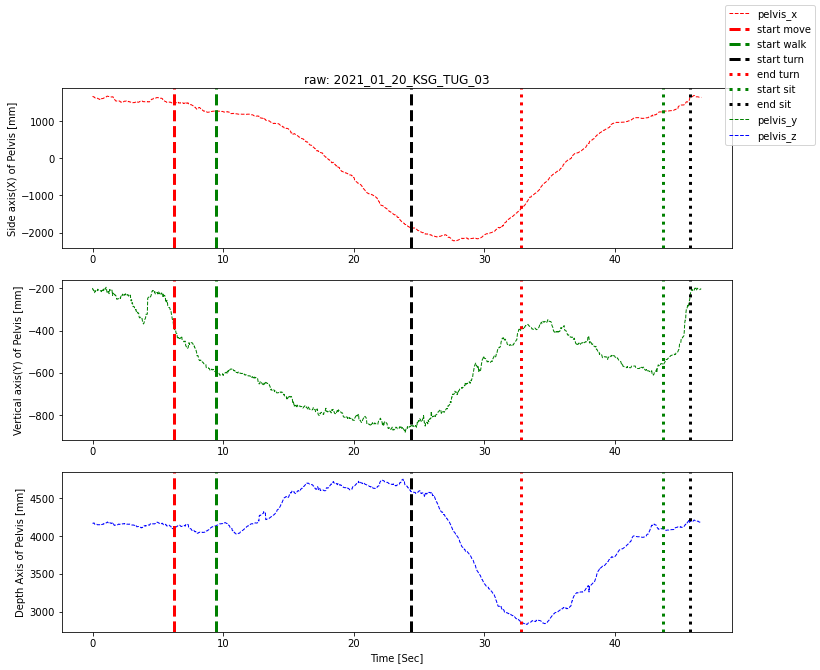

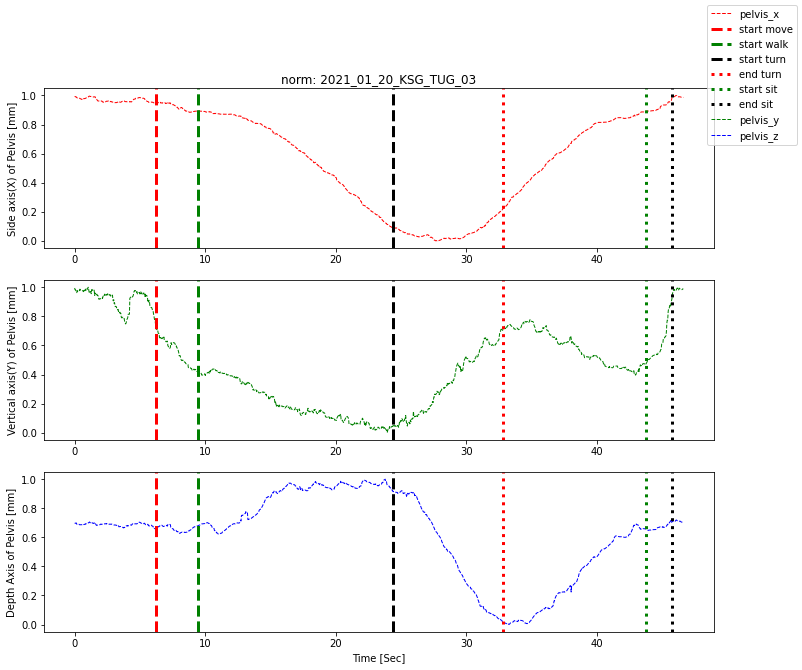

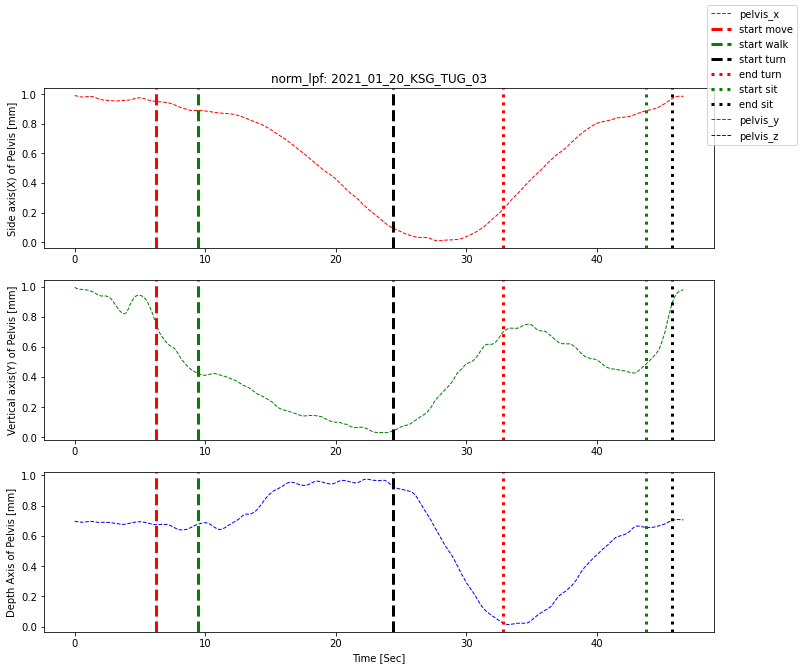

 ---- Finishied!!! Total Trial number:  4


In [12]:
trialNum = 0
csvList = []
numFeature = 4 # timestamp, pelvis x, pelvis y, pelvis z 
numActions = 5  # action list (stting, sit-to-stand , walking, turning, stand-to-sit)
dataset_columns = numFeature + numActions

for dirpath, dirnames, filenames in os.walk(datasetDir):
    actPath = pelvisPath = None
    for filename in filenames:  # -- for each trial..   
        clear_output(wait = True) # cell ouput clear
        # create Save Folder --- save 
        saveDir = dirpath.replace("actLabel", "trainSet")
        saveFile = saveDir.split("/")[-1].replace("\\","_")
        create_saveFolder(saveDir)
        
        if ".csv" in filename :
            # -- read 'actLabel' file == saveResults  , make onehot encoded actLabel 
            if "label" in filename:      
                actPath = dirpath
                print (actPath, "\t file ::", filename)
                actFrame = get_actFrameNumber(actPath, filename, saveDir)
                print("\t ----> 1. actLabel data loaded!! \t act label ====> " +  str(actFrame) + "\n")
                        
             # -- read 'skeleton' file == pelvis data  , calc timestamp_sec
            if "skeleton" in filename:    
                pelvisPath = dirpath          
                frameNum, eachTimestamp_sec, eachrawPelvis_x, eachrawPelvis_y, eachrawPelvis_z = get_pelvisData(pelvisPath,filename)
                pltSkeleton(eachTimestamp_sec, eachrawPelvis_x, eachrawPelvis_y, eachrawPelvis_z, saveDir, saveFile, actFrame, addFolder="raw", save=True) # ---> plot raw
                
                normPelvis_x, normPelvis_y, normPelvis_z = get_normData(eachrawPelvis_x, eachrawPelvis_y, eachrawPelvis_z, normMethod = 'min_max')
                pltSkeleton(eachTimestamp_sec, normPelvis_x, normPelvis_y, normPelvis_z, saveDir, saveFile, actFrame, addFolder="norm", save=True) # ---> plot norm resuls
                 
                # --> norm results is used as an input
                lpfPelvis_x, lpfPelvis_y, lpfPelvis_z = get_LPFData(normPelvis_x, normPelvis_y, normPelvis_z, cutoff_freq=0.5, order=1)
                pltSkeleton(eachTimestamp_sec, lpfPelvis_x, lpfPelvis_y, lpfPelvis_z, saveDir, saveFile, actFrame, addFolder= "norm" + "_lpf",save=True) # plot lpf results
                
            if actPath == pelvisPath:  
                trialNum +=1
                oneHot_actionList = convert_act2oneHot(actFrame, frameNum)
                
                # --> raw skeleton data is used..
                unLabel_rawData = np.array([eachTimestamp_sec, eachrawPelvis_x, eachrawPelvis_y, eachrawPelvis_z]).T 
                unLabel_lpfData = np.array([eachTimestamp_sec, lpfPelvis_y, lpfPelvis_z, lpfPelvis_z]).T
                
                raw_mergeData = np.zeros((len(unLabel_rawData), dataset_columns))
                lpf_mergeData = np.zeros((len(unLabel_lpfData), dataset_columns))
                    
                raw_mergeData[:, :-(numActions)] = unLabel_rawData      # time , pelvis  넣음  (317,4) -- raw data 
                raw_mergeData[:, -(numActions): ] = oneHot_actionList     # (335, 5) one hot encoding 수행한 actionsList
                
                lpf_mergeData[:, :-(numActions)] = unLabel_lpfData      # time , pelvis  넣음  (317,4) -- lpf applied
                lpf_mergeData[:, -(numActions): ] = oneHot_actionList     # (335, 5) one hot encoding 수행한 actionsList          
  
                # -- save data 
                np.savetxt(saveDir + "/" + "raw_labeled_" + saveFile + ".csv", raw_mergeData, fmt='%s', delimiter=',')
                np.savetxt(saveDir + "/" + "lpf_labeled_" + saveFile + ".csv", lpf_mergeData, fmt='%s', delimiter=',')
                
                
print(" ---- Finishied!!! Total Trial number: ",  trialNum)
                    